In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import time
import datetime
import requests
from tiingo import TiingoClient
from yahoofinancials import YahooFinancials
import os
import pandas_datareader.data as web

from tools import *

%config Completer.use_jedi = False

### Download stock general information (meta data)

In [6]:
useful_info = ['symbol', 'sector', 'industry', 'fullTimeEmployees', 'country',
               'maxAge',  'trailingAnnualDividendYield', 
               'payoutRatio', 'navPrice', 'totalAssets', 
               'trailingAnnualDividendRate', 'dividendRate', 
               'beta',  'startDate', 'priceHint', 'marketCap', 'dividendYield', 'exchange', 'shortName', 'longName', 
                'market', 'beta3Year', '52WeekChange', 'morningStarRiskRating', 'forwardEps', 
               'revenueQuarterlyGrowth', 'sharesOutstanding', 'fundInceptionDate', 'annualReportExpenseRatio', 
               'bookValue', 'sharesShort', 'sharesPercentSharesOut', 'fundFamily', 'lastFiscalYearEnd', 
               'heldPercentInstitutions', 'netIncomeToCommon', 'trailingEps', 
               'lastDividendValue', 'SandP52WeekChange', 'priceToBook', 
               'heldPercentInsiders', 'nextFiscalYearEnd', 'mostRecentQuarter', 'shortRatio', 
               'sharesShortPreviousMonthDate', 'floatShares', 'enterpriseValue', 'threeYearAverageReturn', 
               'lastSplitDate', 'lastSplitFactor', 'legalType', 'lastDividendDate', 
               'morningStarOverallRating', 'earningsQuarterlyGrowth', 'dateShortInterest', 'pegRatio',
               'lastCapGain', 'shortPercentOfFloat', 'sharesShortPriorMonth', 
               'impliedSharesOutstanding', 'category', 'fiveYearAverageReturn', 'longBusinessSummary'
               ]

def get_meta_data_information(symbols, useful_info):
    useful_infos = []
    for i, symbol in enumerate(symbols):
        print(f"{i+1}:{symbol}", end="  ")
        try:
            ticker = yf.Ticker(symbol)
            info = ticker.info
            useful_info = {x:info[x] for x in useful_info}
            useful_infos.append(useful_info)
        except Exception as e:
            print(e)
    return useful_infos

symbols = pd.read_excel("../Data/+Stocks_lists/All_US_stocks_above2B_MCap.xlsx")['Symbol'].values[:]

# meta_data = get_meta_data_information(symbols, useful_info)
# meta_data = pd.DataFrame(meta_data)
# meta_data.to_csv("All_US_stocks_above2B_MCap_meta_data.csv", index=False)
# meta_data.head(3)

### Get list of symbols (tickers)

In [42]:
# s1 = pd.read_excel("../Data/+Stocks_lists/2021-12. CanadianStock_top100.xlsx")['Symbol']
# s2 = pd.read_csv("../Data/+Stocks_lists/companiesmarketcap.com - Largest Canadian companies by market capitalization.csv")['Symbol']
# s1 = [x[:-3].upper() for x in s1]
# np.array((set(s1) - set(s2)))

In [17]:
ticker_family = 'TSX' # 'Nasdaq_NYSE' 

if ticker_family == 'SP500':
    sp500 = get_sp500_list()
    symbols = sp500['Symbol'].values

elif ticker_family == 'Nasdaq_NYSE':
    symbols_df = pd.read_excel("../Data/+Stocks_lists/All_US_stocks_above2B_MCap.xlsx")
    symbols = symbols_df['Symbol'].values[:]
    
elif ticker_family == 'Nasdaq':
    stock_exchange = 'Nasdaq'
    nasdaq = pd.read_csv("Assorted/20210615. nasdaq_screener_1623818257700.csv")[['Symbol', 'Name', 'Market Cap', 'Last Sale']]
    bins = [-1, 3e+8, 2e+9, 10e+9, 100e+9, 10000e+9]
    nasdaq['Mkt_cap_label'] = pd.cut(nasdaq['Market Cap'], bins=bins, labels=['Penny','Small', 'Medium', 'Large', "Mega"])
    symbols = nasdaq[nasdaq['Mkt_cap_label'].isin(['Mega','Large', 'Medium'])]['Symbol'].values

elif ticker_family == 'TSX':
    stock_exchange = 'tsx'
    tsx_symbols_df = pd.read_excel("../Data/+Stocks_lists/2021-12. CanadianStock_top100.xlsx")
    symbols = tsx_symbols_df['Symbol'].astype(str).values 
    # symbols = [x.replace('.','-') + '.to' for x in symbols ] # if '.' not in x
    # symbols.remove('nan.to')
    # symbols.append('NA.to')

elif ticker_family == "SPX_Sectors":
    symbols= ['XLB', 'XLV', 'XLP', 'XLY', 'XLE', 'XLF', 'XLI', 'XLK', 'XLU', 'XLRE', 'XLC']

    
elif ticker_family == 'Indices':
    symbols = ['SPY', '^DJI', '^GSPC', 'NDX']

print('Number of Symbols =', len(symbols))
# symbols_df[:4]

Number of Symbols = 100


In [ ]:

def download_stock_price_data(symbol, start, end, option='yahoo_finance', interval='1d', verbose=False):
    try:
        if option == 'yahoo_finance':
            # https://github.com/ranaroussi/yfinance
            # 
            # print(f"Download {symbol} data with Yahoo Finance API")
            # Option 1
            # Interval: 1m, 5m, 15m, 30m, 60m, 1h, 1d, 1wk,1mo,
            # auto_adjust = True: so all the presented prices areadjusted for potential corporate actions, such as splits.
            data = yf.download(symbol, start=start, end=end, progress=False, interval=interval)

        elif option == "YahooFinancials":
            # Option 3
            yahoo_financials = YahooFinancials(symbol)
            data = yahoo_financials.get_historical_price_data(start_date=start, end_date=end, 
                                                              time_interval='daily')
            data = pd.DataFrame(data[symbol]['prices'])        


        elif option == "alpha_vintage":
            ALPHA_VANTAGE_API_KEY = 'I3Z5IQNTGCQ7IED4'  # J4RADOTW5DBN344U
            print(f"{i+1}/{len(symbols)}: Download {symbol} data with Alpha Vintage using Pandas data_reader API")
            data = web.DataReader(symbol, "av-daily-adjusted", # av-daily-adjusted / av-daily
                                  start=start, end=end,
                                  api_key=ALPHA_VANTAGE_API_KEY)

        return data
    
    except Exception as e:
        print(f"Got an error: {e}")


def download_stock_price_data_wrapper(symbols, 
                                      start_date, prev_end_date, new_end_date, fake_end_date,
                                      option='yahoo_finance', interval='1d',
                                      save_folder='../Data/Daily/US_Market/latest'):

    interval_dict = {'1d': 'daily', '1h':'hourly', '60min':'hourly', '60m':'hourly', '1mo':'Monthly'}
    incomplete_downloads = dict()
    for i, symbol in enumerate(symbols[:]):
        print(f"{i+1} : {symbol} \t", end='')

        time_period = f"{start_date.replace('-', '')}_to_{prev_end_date.replace('-', '')}"
        save_file_name_old = f'{save_folder}/{symbol}_USD_{time_period}_{interval_dict[interval]}_{option}.csv'

        time_period = f"{start_date.replace('-', '')}_to_{new_end_date.replace('-', '')}"
        save_file_name_new = f'{save_folder}/{symbol}_USD_{time_period}_{interval_dict[interval]}_{option}.csv'

        if os.path.exists(save_file_name_new):
            data = pd.read_csv(save_file_name_new).set_index("Date")
            last_row_date = data.iloc[-1, :].name
            if last_row_date == new_end_date:
                print('{:>2d}: {:<10s} Has already been downloaded until {:<12s}'.format(i+1, symbol, last_row_date))
                continue
            else:
                print('{:>2d}: {:<10s} Download from {:<12s} to {:^12s}'.format(i+1, symbol, last_row_date, new_end_date))
                new_data = download_stock_price_data(symbol, start=last_row_date, end=fake_end_date, interval=interval)
                new_data.index = new_data.index.astype(str)
                merged_data = pd.concat((data, new_data))
                merged_data = merged_data[~merged_data.index.duplicated(keep='first')]
                os.remove(save_file_name_new)
                merged_data.to_csv(save_file_name_new)
                if merged_data.index[-1] != new_end_date:
                    incomplete_downloads[symbol] = merged_data.index[-1]

        elif os.path.exists(save_file_name_old):
            data = pd.read_csv(save_file_name_old).set_index("Date")
            last_row_date = data.iloc[-1, :].name
            print('{:>2d}: {:<10s} Download from {:<12s} to {:^12s}'.format(i+1, symbol, last_row_date, new_end_date))
            new_data = download_stock_price_data(symbol, start=last_row_date, end=fake_end_date, interval=interval)
            new_data.index = new_data.index.astype(str)
            merged_data = pd.concat((data, new_data))
            merged_data = merged_data[~merged_data.index.duplicated(keep='first')]
            os.remove(save_file_name_old)
            merged_data.to_csv(save_file_name_new)
            if merged_data.index[-1] != new_end_date:
                incomplete_downloads[symbol] = merged_data.index[-1]

        else:
            print('{:>2d}: {:<10s} Download from scratch'.format(i+1, symbol))
            data = download_stock_price_data(symbol, start=start_date, end=fake_end_date, interval=interval)
            data.to_csv(save_file_name_new)
            if data.index[-1] != new_end_date:
                incomplete_downloads[symbol] = data.index[-1]

    print("Done")

In [8]:
# symbols = symbols_df[symbols_df['Market Cap'] > 50]['Symbol'].values[:]
print(len(symbols))

100


In [9]:
# from pandas_datareader.nasdaq_trader import get_nasdaq_symbols
# nasdaq_symbols_df = get_nasdaq_symbols()
# print(len(nasdaq_symbols_df))
# nasdaq_symbols_df.head(2)

## Downalod Data

In [18]:
%%time
today = datetime.datetime.today().strftime('%Y-%m-%d')

start_date = "2000-01-01"
prev_end_date = "2022-03-23"
new_end_date = str(today) # "2022-02-02" # str(today)
fake_end_date = str(datetime.date.today() + datetime.timedelta(days=1)) # "2022-02-03"

download_stock_price_data_wrapper(symbols[3:4], start_date, prev_end_date, new_end_date, fake_end_date, interval='1d',
                                 save_folder='../Data/Daily/TSX/')

1 : BAM.to 	 1: BAM.to     Download from scratch
Done
Wall time: 271 ms


In [13]:
tsx_symbols_df = pd.read_excel("../Data/+Stocks_lists/CanadianStock_Dec2021_top100.xlsx")
selected_symbols = ['TIXT.to', 'CDAY.to', 'FSV.to', 'CAE.to', 'AEM.to', 'Shop.to']
selected_symbols = ['AEM.to', 'CCO.to', 'NCM.to', 'CDAY.to', 'CP.to', 'TIXT.to', 'BEP-UN.to']
selected_symbols = ['CSU.to', 'WCN.to', 'TRI.to','ATD.to', 'NTR.to']

tsx_symbols_df.set_index('Symbol').loc[selected_symbols][['Company', 'Sector', 'Market Cap', 'Last Sale']]

,Company,Sector,Market Cap,Last Sale
Symbol,,,,
CSU.to,CONSTELLATION SOFTWARE INC,Technology Services,47.788,2290.01
WCN.to,WASTE CONNECTIONS INC (CA),Industrial Services,43.438,167.48
TRI.to,THOMSON-REUTERS CORP,Technology Services,72.528,149.72
ATD.to,ALIMENTATION COUCHE-TARD,Retail Trade,54.100,51.58
NTR.to,NUTRIEN LTD,Process Industries,53.220,95.22


## Download SPX and analyze it

In [ ]:
download_stock_price_data_wrapper(['^GSPC'], 
                                  '1970-01-01', '2021-12-31', '2021-12-31', '2022-01-01', interval='1mo',
                                 save_folder='../Data/Daily/US_Market/Indices')

In [198]:
spy_mo = download_stock_price_data('^GSPC', start='1970-01-01', end='2021-12-04', interval='1mo')
spy_mo

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1985-01-01,167.199997,180.270004,163.360001,179.630005,179.630005,2673710000
1985-02-01,179.630005,183.949997,177.750000,181.179993,181.179993,2194620000
1985-03-01,181.179993,183.889999,176.529999,180.660004,180.660004,2153090000
1985-04-01,180.660004,183.610001,177.860001,179.830002,179.830002,1981880000
1985-05-01,179.830002,189.979996,178.350006,189.550003,189.550003,2350340000
...,...,...,...,...,...,...
2021-08-01,4406.859863,4537.359863,4367.729980,4522.680176,4522.680176,63217960000
2021-09-01,4528.799805,4545.850098,4305.910156,4307.540039,4307.540039,66268850000
2021-10-01,4317.160156,4608.080078,4278.939941,4605.379883,4605.379883,61874700000


In [235]:
n = 3
spy_pc = spy_mo.dropna()[['Close']].pct_change(n).dropna() * 100
spy_pc.columns = [f'Percent of change in {n} months']
spy_pc['MovingAvg_3'] = spy_pc[f'Percent of change in {n} months'].rolling(3).mean() # , min_periods=1
spy_pc['MovingAvg_6'] = spy_pc[f'Percent of change in {n} months'].rolling(6).mean() # , min_periods=1
spy_pc['MovingAvg_12'] = spy_pc[f'Percent of change in {n} months'].rolling(12).mean() # , min_periods=1
spy_pc['MovingAvg_18'] = spy_pc[f'Percent of change in {n} months'].rolling(18).mean() # , min_periods=1

spy_pc.tail(5)

,Percent of change in 3 months,MovingAvg_3,MovingAvg_6,MovingAvg_12,MovingAvg_18
Date,,,,,
2021-08-01,7.577592,6.956185,8.253869,7.661270,6.251364
2021-09-01,0.233625,4.310517,7.330721,6.974595,7.375512
2021-10-01,4.780607,4.197275,6.032264,7.375935,8.180360
2021-11-01,2.931665,2.648633,4.802409,7.331409,8.173812
2021-11-30,6.023391,4.578554,4.444536,6.859352,7.399952


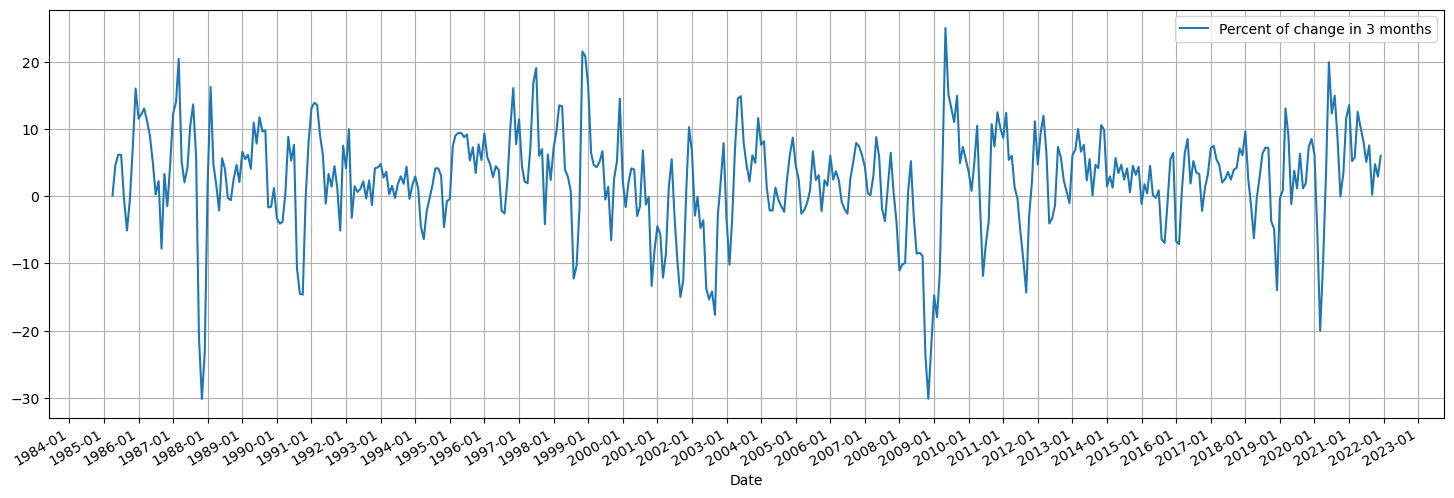

In [236]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(18, 6), dpi=100)
x = 0
spy_pc.iloc[:, x:x+1].plot(kind='line', ax=ax, x_compat=True) # mdates.MonthLocator()
ax.grid(which='major', axis='both')
# ax.xaxis.set_major_locator(plt.MaxNLocator( 30))
# ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
# fig.autofmt_xdate()
fig.savefig("SPY_chage_3_months.jpg")

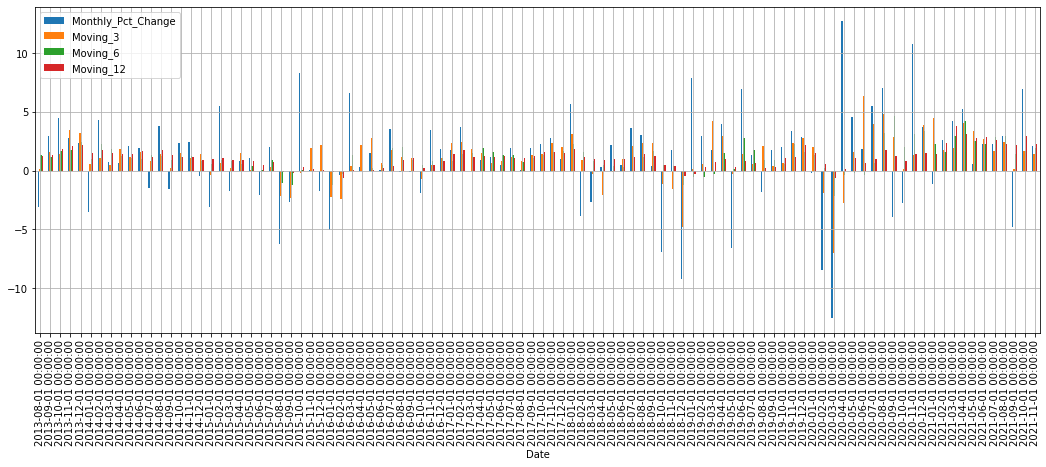

In [169]:
fig, ax = plt.subplots(figsize=(18, 6))
spy_pc[-100:].plot(kind='bar', ax=ax, lw=2, )
ax.grid(which='major')


In [ ]:
iwv_mo = download_stock_price_data('IWV', start='1970-01-01', end='2021-11-23', interval='1mo')

In [185]:
iwv_mo_pc = iwv_mo.dropna()[['Close']].pct_change(12).dropna() * 100
iwv_mo_pc

,Close
Date,
2001-06-01,-13.687372
2001-07-01,-14.564594
2001-08-01,-25.319472
2001-09-01,-28.971529
2001-10-01,-25.918766
...,...
2021-07-01,36.665793
2021-08-01,31.188113
2021-09-01,30.218179
